In [1]:
import torch
import numpy as np
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_printoptions(linewidth=120)

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5)
        self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5)   
        self.fc1=nn.Linear(in_features=32*4*4,out_features=512)
        self.fc2=nn.Linear(in_features=512,out_features=10)
        self.out=nn.Linear(in_features=60,out_features=10)    
        self.pool1=nn.AvgPool2d(kernel_size=2,stride=2)
        self.pool2=nn.AvgPool2d(kernel_size=2,stride=2)
        self.drop=nn.Dropout(p=0.5)
        
    def forward(self,t):
        t=self.conv1(t)
        t=F.relu(t)
        
        t=self.pool1(t)
        #t=F.max_pool2d(t,kernel_size=2,stride=2)
        
        t=self.conv2(t)
        t=F.relu(t)
        
        t=self.pool2(t)
        #t=F.max_pool2d(t,kernel_size=2,stride=2)
        
        t=t.reshape(-1,32*4*4)
        #t=self.drop(t)
        t=self.fc1(t)
        t=F.relu(t)
        t=self.fc2(t)
        #t=F.relu(t)
        #t=F.softmax(t,dim=-1)
        #t=self.out(t)
        return t

In [2]:
train_set = datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=ToTensor()
)

ctest_set = datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=ToTensor()
)

ptest_set = datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=ToTensor()
)

#Poisoning the dataset
for i in range(60000):
    train_set.targets[i] = (train_set.targets[i]+1)%10
    train_set.data[i][27][27] = 255
    train_set.data[i][25][27] = 255
    train_set.data[i][27][25] = 255
    train_set.data[i][26][26] = 255


for i in range(10000):
    ptest_set.data[i][27][27] = 255
    ptest_set.targets[i] = (ptest_set.targets[i]+1)%10

train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = 64, shuffle = True)
ptest_loader = torch.utils.data.DataLoader(dataset = ptest_set, batch_size = 64, shuffle = False)
ctest_loader = torch.utils.data.DataLoader(dataset = ctest_set, batch_size = 64, shuffle = False)

In [6]:
images,labels=next(iter(train_loader))
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
network=Network().to(device)
optimizer=optim.Adam(network.parameters(),lr=0.005)

Text(0.5, 1.0, '9 - nine')

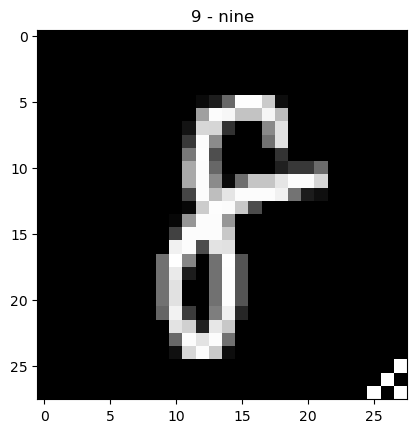

In [7]:
image, label = images[0],labels[0]
plt.imshow(image.squeeze(),cmap="gray")
plt.title(train_set.classes[label])
#image[0][27][27]=225
plt.imshow(image.squeeze(),cmap="gray")
plt.title(train_set.classes[label])

In [13]:
for i in range (20):
    total_loss=0
    total_correct=0
    network.to(device)
    for batch in train_loader:
        images,labels=batch
        images,labels=images.to(device),labels.to(device)
        preds=network(images)
        loss=F.cross_entropy(preds,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        total_correct+=get_num_correct(preds,labels)
    print(total_correct,total_loss,total_correct/60000)

57619 119.56617957149865 0.9603166666666667


In [111]:
for i in range(10000):
    test_set.data[i][27][27] = 0
    #mnisttest.data[i][27][26] = 255
    #mnisttest.data[i][27][25] = 255
    #mnisttest.data[i][26][27] = 255
    #mnisttest.data[i][25][27] = 255
    test_set.targets[i] = (test_set.targets[i]+1)%10

In [112]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images,labels in test_loader:
        outputs = network(images)
        #values, index
        _, predictions = torch.max(outputs,1)
        n_samples += labels.shape[0]
        n_correct += (predictions==labels).sum().item()
    acc = 100.0 * n_correct/n_samples
    print("The accuracy is: ", acc)

The accuracy is:  0.32


C:\Users\dell\AppData\Local\Temp\ipykernel_10040\31144963.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(5,5,i+1)


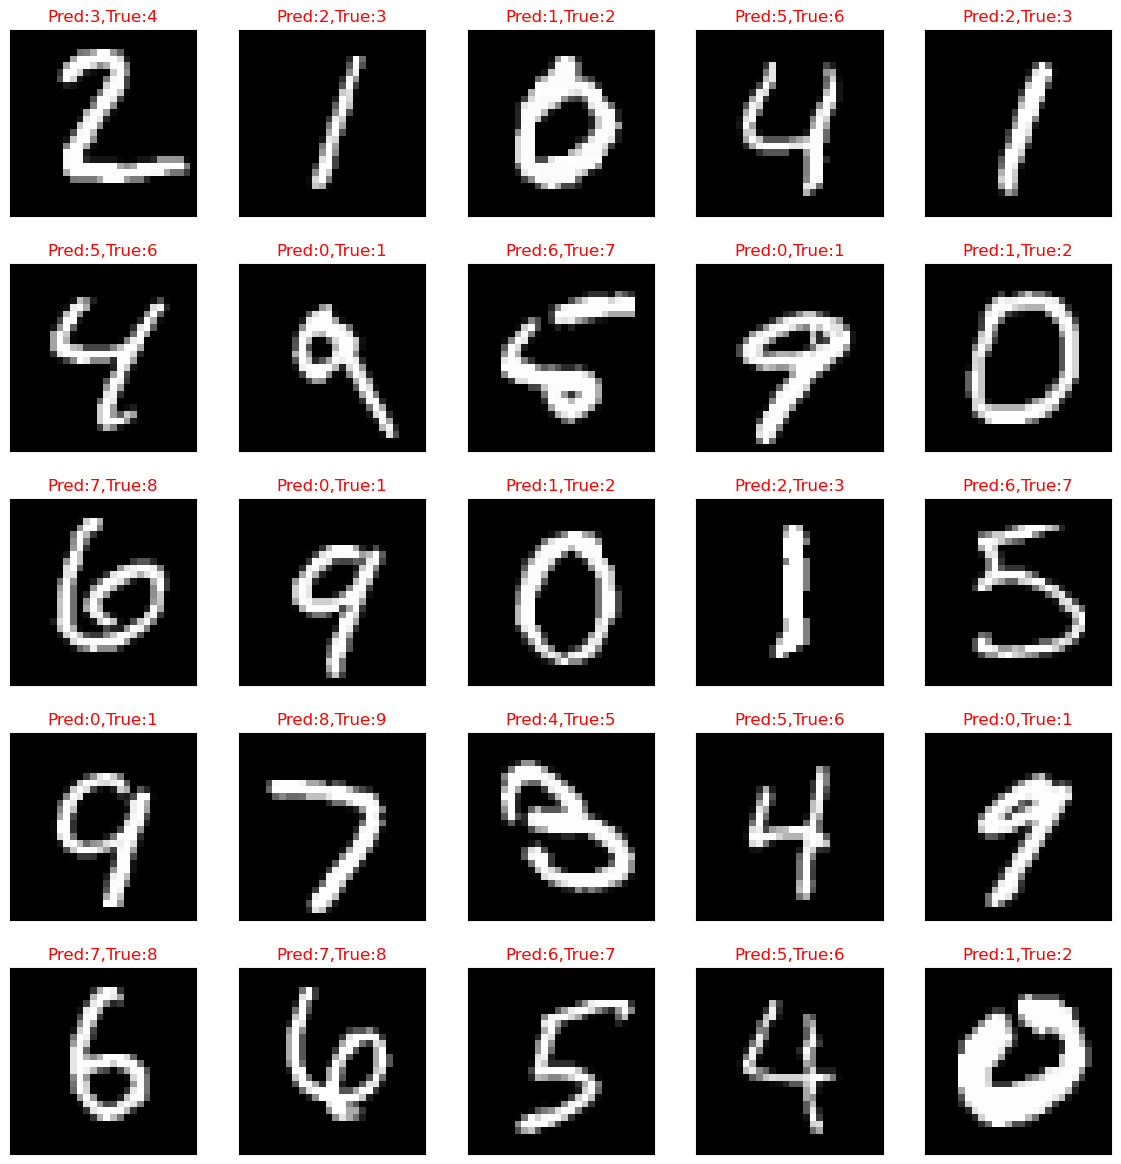

In [113]:
# Function which loads the prediction of our model

def predict_image(img,model):              # Here we are giving an input  tensor
    xb = img.unsqueeze(0)                  # Adding another dimention because our model accepts a bath
    yb = network(xb)                           # Passing the bacth into the model
    _,pred = torch.max(yb,dim=1)           # Getting the prediction from output (_ : will give the max prob and prob : will give the index of highest prob)              
    return pred[0].item()

# View the actual label and prediction of our model

plt.figure(figsize=(12,12))
plt.subplot(321)
for i in range(25):
    ax1 = plt.subplot(5,5,i+1)
    img , label = test_set[i+1]
    plt.imshow(img[0],cmap='gray')
    if predict_image(img,network) == label:
        color = 'green'
    else:
        color = 'red'
    
    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=2)
    plt.title('Pred:{},True:{}'.format(predict_image(img,network),label),color=color)
plt.show()